# HW 0x03

## Ayush Kakkanat

## Imports

In [128]:
from numpy import array, arange, zeros, transpose
from matplotlib import pyplot, rc
from math import pi, cos, sin

## The System Models

The following differential equations represent the kinematics of a differential drive robot:

$$
\begin{array}{rl}
\frac{dx}{dt}      &= \frac{r}{2}*cos(\theta) \left(\omega_r + \omega_l  \right) \\
\frac{dy}{dt}      &= \frac{r}{2}*sin(\theta) \left(\omega_r + \omega_l  \right) \\
\frac{d\theta}{dt} &= \frac{r}{s} \left(\omega_r - \omega_l  \right) \\
\end{array}
$$

The preceding equations can be combined into a single vector equation so that we can solve it using vector based ODE solution techniques.

$$
\begin{array}{rl}
\frac{d}{dt}
    \begin{bmatrix}
        x \\
        y \\
        \theta
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{r}{2}*cos(\theta) \left(\omega_r + \omega_l  \right) \\
    \frac{r}{2}*sin(\theta) \left(\omega_r + \omega_l  \right) \\
    \frac{r}{s} \left(\omega_r - \omega_l  \right) \\
\end{bmatrix} \\
\end{array}
$$

The code below defines the parameters obtained from actual measurements for the robot. Arbitrary radius and valocity values are also provided which will be used in the calculation of angular velocity to be used in solving the differential model with an RK4 solver. The system outputs of desire are the location and orientation values (x, y, and ${\theta}$).

### System Parameters
<style>
td,th {
  font-size: 20px
}
</style>
| Parameter | Value | Unit |
| :-- | --- | --- |
| wheel diameter, d | 2.75 | in |
| wheel separation, s | 5.75 | in |
| tangential robot velocity, v | 3 | in/s |
| radius of circle path, R | 10 | in |

In [129]:
#Parameters
d = 2.75
r = d/2
v = 3
R = 10
s = 5.75
wl = (v - (v/R)*(s/2))/r   # left wheel angular velocity
wr = (v + (v/R)*(s/2))/r   # right wheel angular velocity

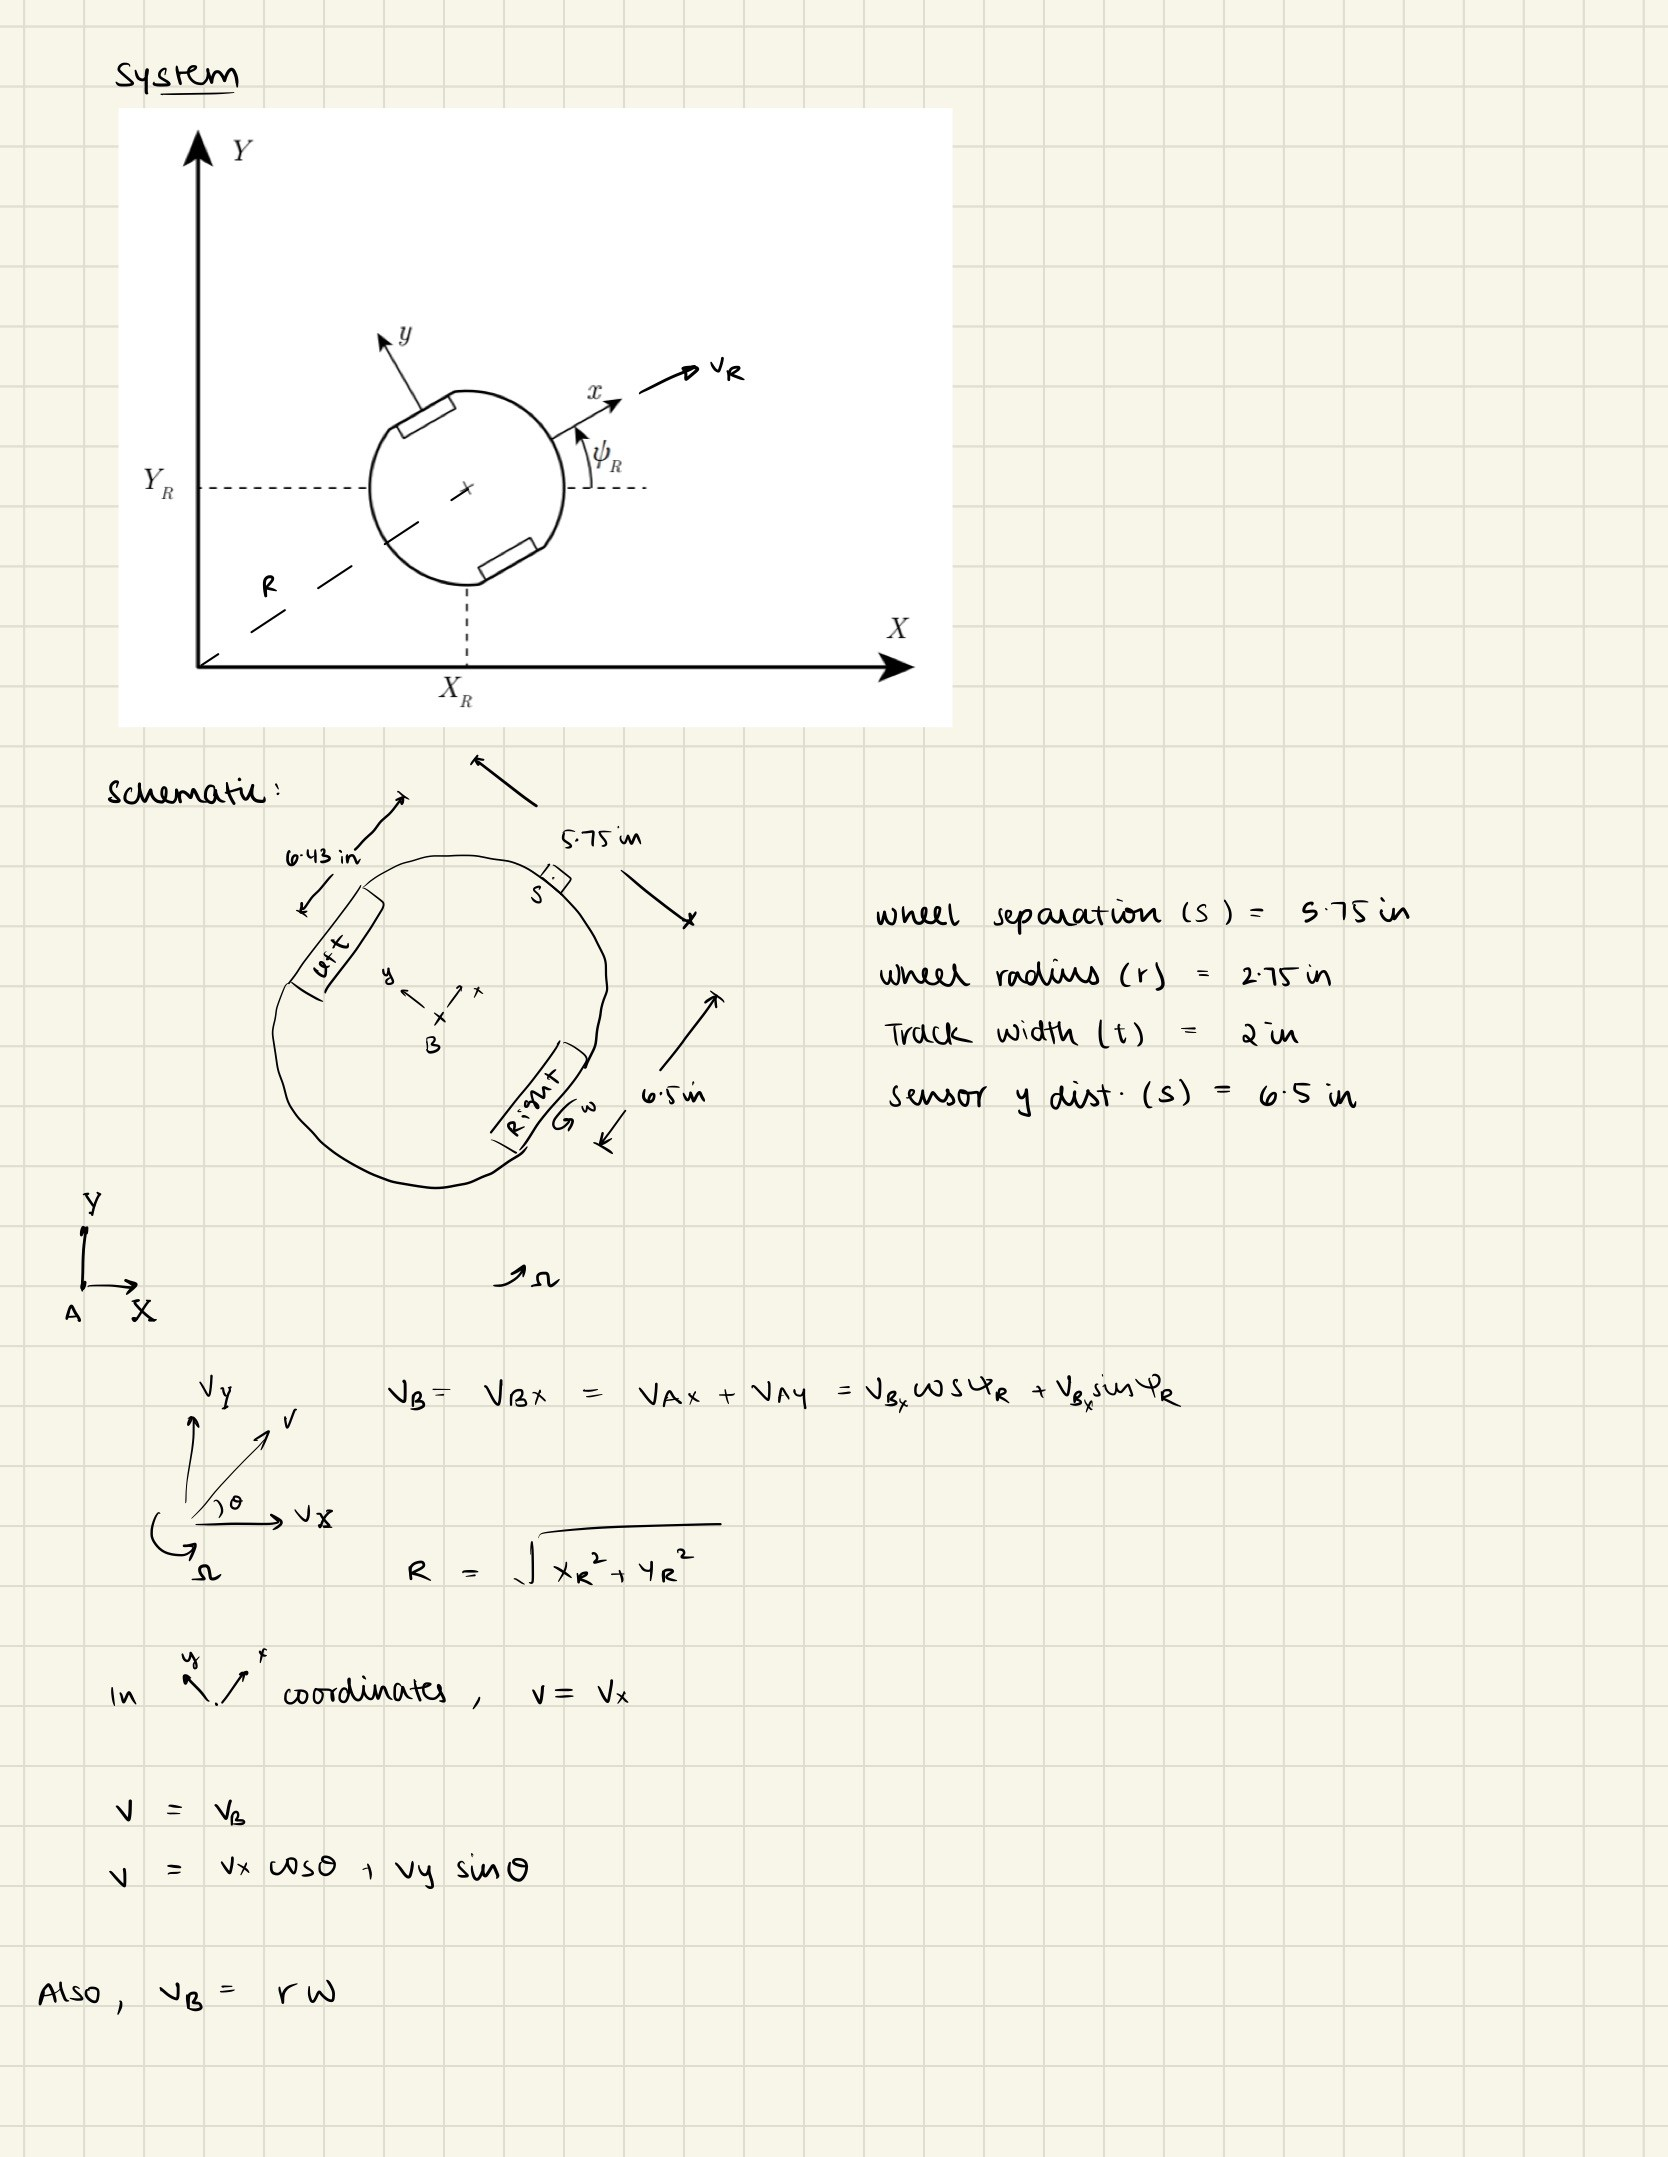

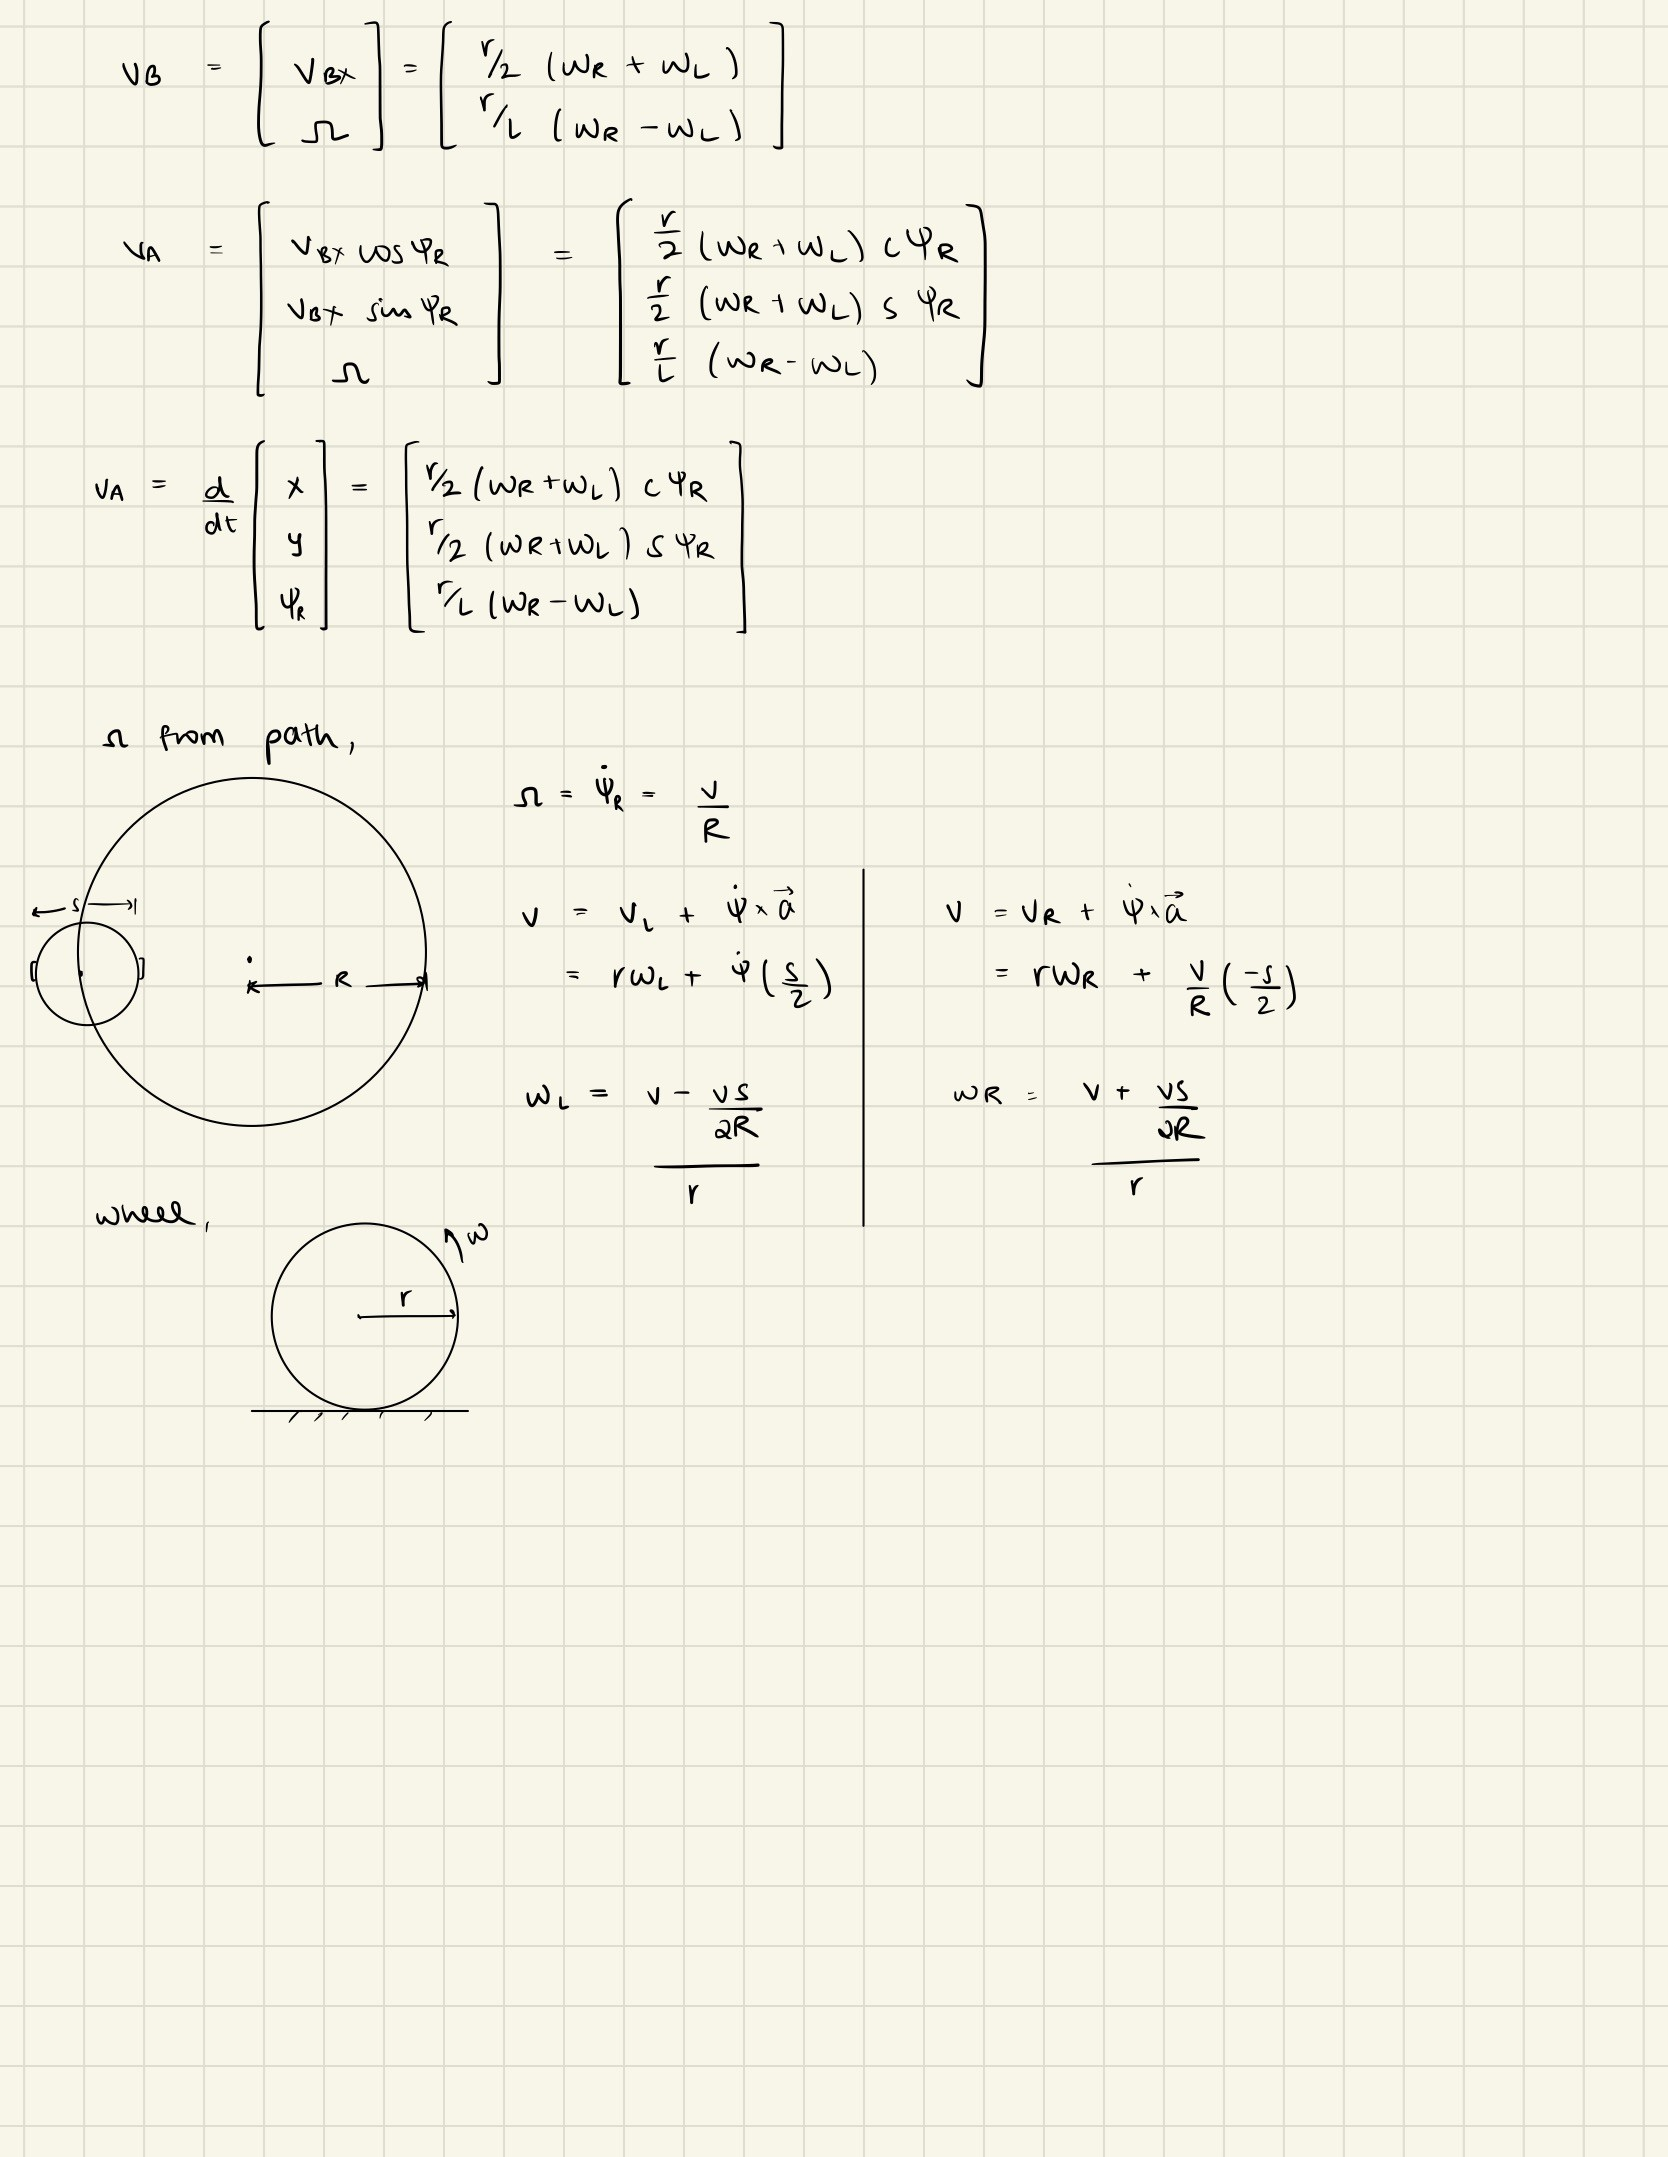

In [130]:
def system_eqn_OL(t, x):
    '''!@brief      Implements both state equations and output equations for the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector and the output
                    vector for a given simulation step
    '''
        
    th = x[2];   # angle swept by robot
    x_dot = (r/2)*cos(th)*(wr+wl)   # horizontal robot speed
    y_dot = (r/2)*sin(th)*(wr+wl)   # vertical robot speed
    th_dot = (wr-wl)*r/s   # robot angular velocity around circle
    
    # State-to-state coupling matrix
    u= array([[ wr ], 
              [ wl ]])
    
    # State equations
    xd = array([[ x_dot  ],
                [ y_dot  ],
                [ th_dot ]]);
    
    # Output Equations
    y = array([[ x[0] ],
               [ x[1] ],
               [ x[2] ]]); 
    
    return xd, y

## Forward Euler Solver
For this example, as provided a simple solver will be implemented for you. That is, a first-order forward Euler solver is implemented below. It can be used as a template or example that you may extend to use a higher-order integration method, such as the Runge-Kutta method, see below for additional details.

The details of the solver will not be covered here in great depth, however it is important to understand the integration method in some depth to complete the assignment. The fundamental assumption used in a first-order solver is that over a small window of time the state of the system changes at a constant rate. That is, the derivative of the state vector, $\dot{\mathbf{x}}$, is assumed constant over a short window of time, $\Delta t$. This assumption leads directly to an integration algorithm called Euler's method. There are multiple formulations of Euler's method, and the simplest form is the Forward Euler method. The method predicts future states of the system based on knowledge of the present state and its derivative at a given instant in time. It is called a forward Euler method because it uses information at a given step $n$ to predict the future state at step $n+1$.

$$
\begin{array}{rl}
\frac{\Delta \mathbf{x}}{\Delta t} &= \mathbf{\dot{x}}_n \\
\Delta \mathbf{x} &= \mathbf{\dot{x}}_n \Delta t \\
\mathbf{x}_{n+1} - \mathbf{x}_{n} &= \mathbf{\dot{x}}_n \Delta t \\
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \mathbf{\dot{x}}_n \Delta t
\end{array}
$$
where, 
$$
\begin{array}{rl}
\mathbf{\dot{x}}_n &= \mathbf{f}(t,\mathbf{x}_n).
\end{array}
$$

In [131]:
def Euler_solver(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a first-order forward euler solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    
    # Define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])
    
    # Determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])
    
    # Preallocate an array of zeros to store output values
    yout = zeros([len(tout),r])
    
    # Initialize output array with intial state vector
    xout[0][:] = x_0.T

    # Iterate through the algorithm but stop one cycle early because
    # the algorithm predicts one cycle into the future
    for n in range(len(tout)):
        
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = xout[[n]].T
        
        # Pull out the present value of time
        t = tout[n]
        
        # Evaluate the function handle at the present time with the
        # present value of the state vector to compute the derivative
        xd, y = fcn(t, x)
        
        # Apply the update rule for Euler's method. The derivative value
        # must be transposed back to a row here for the dimensions to line up.
        xout[n+1] = xout[n] + xd.T*tstep
        yout[n] = y.T
    
    return tout, yout

## Runge-Kutta Method (4th-order)
The following algorithm is presented without derivation, but is a marked improvement over Euler's method presented above. The integration technique is fourth-order, instead first-order, so has a much smaller truncation error for a given step size. Using an "RK" solver will allow you to use a much more reasonable step size and still get a solution of reasonable accuracy. The algorithm is similar to Euler's method, however it splits the window of time, $\Delta t$, in half and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is then used in a standard Euler step.
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n) \\
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t).
\end{array}
$$

In [132]:
def RK4_solver(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a fourth-order range-kutta solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    
    # Define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])
    
    # Determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])
    
    # Preallocate an array of zeros to store output values
    yout = zeros([len(tout),r])

    # Initialize output array with intial state vector
    xout[0][:] = x_0.T

    # Iterate through the algorithm but stop one cycle early because
    # the algorithm predicts one cycle into the future
    for n in range(len(tout)):
        
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = xout[[n]].T
        
        # Pull out the present value of time
        t = tout[n]
        
        # Evaluate the function handle at the present time with the
        # present value of the state vector to compute the derivative
        k1, y1 = fcn(t, x)
        k2, y2 = fcn(t + 0.5*tstep, x + 0.5*k1*tstep)
        k3, y3 = fcn(t + 0.5*tstep, x + 0.5*k2*tstep)
        k4, y4 = fcn(t + tstep, x + k3*tstep)
        
        # Apply the update rule for Euler's method. The derivative value
        # must be transposed back to a row here for the dimensions to line up.
        xout[n+1] = xout[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4).T*tstep
        yout[n] = y1.T
    
    return tout, yout

## Running the Open-Loop Simulation

In [148]:
# The following initial conditions will be used by both the open-loop and
# closed-loop simulations
x_0 = array([ [0], 
              [0],
              [0] ])
# Solve the open loop system over a 0.1 second time window with 1 ms steps
t_OL, y_OL = RK4_solver(system_eqn_OL, x_0, [0, 40], 1e-3)

## Plotting the Open-Loop Simulation Results

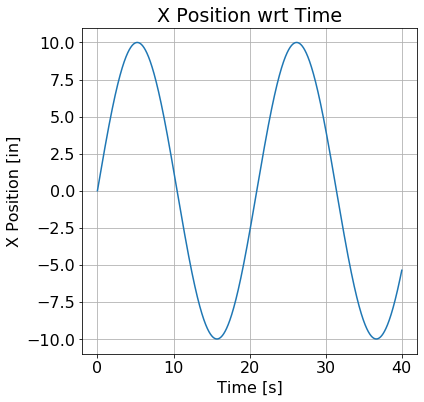

In [149]:
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(6,6))
pyplot.plot(t_OL, y_OL[:,0])
pyplot.xlabel('Time [s]')
pyplot.ylabel('X Position [in]')
pyplot.grid()
pyplot.title('X Position wrt Time');

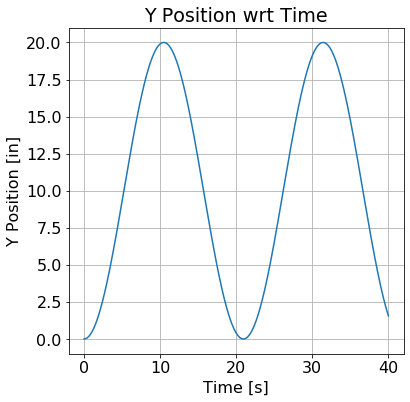

In [150]:
pyplot.figure(figsize=(6,6))
pyplot.plot(t_OL, y_OL[:,1])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Y Position [in]')
pyplot.grid()
pyplot.title('Y Position wrt Time');

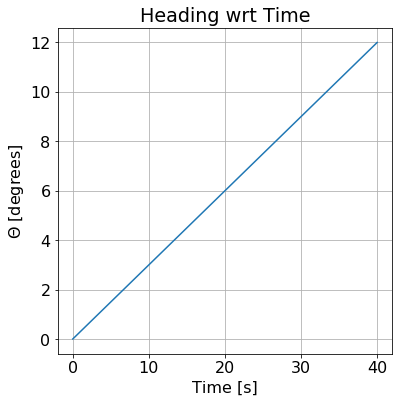

In [153]:
pyplot.figure(figsize=(6,6))
pyplot.plot(t_OL, y_OL[:,2])
pyplot.xlabel('Time [s]')
pyplot.ylabel('${\Theta}$ [degrees]')
pyplot.grid()
pyplot.title('Heading wrt Time');

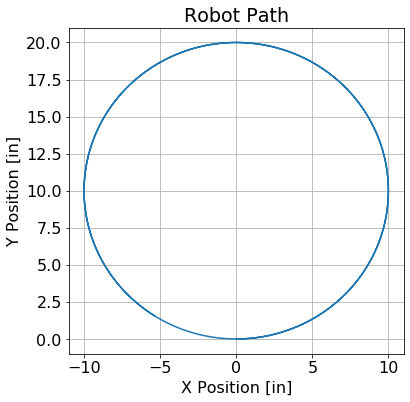

In [151]:
pyplot.figure(figsize=(6,6))
pyplot.plot(y_OL[:,0], y_OL[:,1])
pyplot.xlabel('X Position [in]')
pyplot.ylabel('Y Position [in]')
pyplot.grid()
pyplot.title('Robot Path');

## Discussion Questions

1.	Explore the validity of the no-slip assumption and any other assumptions required for the kinematic model in favor of a full dynamic model. Consider things like how the motors may or may not easily integrate with the model, how the mass and friction properties of the system may influence the model, and any other effects that may not match the idealized nature of the kinematic model. Is the kinematic model good enough for our purposes?

The kinematic model is not sufficient for our purposes. The assumptions made about no slip and no drift may or may not be accurate. There can be variations in the power delivered by the motors to the wheels, friction, inertia, or jerk which could cause the kinematic model to be inaccurate. However, it is important to note that while the kinematic model is not good for detailed simulations, it is a good initial estimation due to the assumptions made which are a largely accurate for most cases. A closed loop system with a controller and motor encoders would aid in improving the kinematic model without having to model the weight, forces, friction, etc.

2.	One of the problems with models like this is that significant deviation or drift will occur between the simulation and the behavior of the real vehicle, especially when accumulated over a long simulation. The concept of dead reckoning is that we can predict the position of a system simply by integrating its velocity or acceleration over time. Naturally, small deviations, like those caused by minor wheel slip, add up over time. A small error in velocity, once integrated over time to produce position, can lead to wildly inaccurate estimations of position. How can we correct this drift error? What other information would help us keep our simulated model tracking with reality? Hint: consider what kind of sensors may be added to the robot to measure the value of your selected state variables.

Drift can be accounted for in our simulation by adding noise. The noise can be added to the input wl and wr values of the wheel angular velocity. In the real world, we can account for it by the addition of sensors. In particular, an IMU would play a big role in fixing drift. It can be calibrated on startup and using the accelerometer and gyroscope data, the yaw position of robot can be taken and compared to expected values. This would allow us to note if there is drift occuring. A feedback control system can be implemented to ensure that the velocity and swept angle by the robot is as expected.

3.	While this is not a controls course, you will need to implement some kind of controller on your robot to complete the term project. For this question, investigate ways in which you may incorporate feedback into your system to make the robot move in ways that will be advantageous for the term project. Address nuances such as: a) What sensor inputs will be useful for feedback and b) How you might split up a complicated path into segments such as straight lines, circular arcs, in-place turns, etc

The term project will require a minimum of 4 reflectance sensors which will detect the white and black colours of the path. Their placement will be such that the outer two sensors will keep track of the white outside the line and the inner two sensors will keep track of the black within the line. With the relevant change in colour value, by implementing a finite state machine, the robot will either move forward, turn left, or turn right. In this manner it will be able to navigate straight lines, arcs, in-place turns, etc. without specifically defining a control loop with gains, but in effect acts as a controller.

4.	 Is it possible to determine the orientation and location of the robot after it has followed a specific path simply by knowing the angle swept out by each wheel? If not, would it be possible to know the orientation and location with a time-history of the angle swept out by each wheel? If you know the robot’s orientation and location, can you figure out the angle swept out by each wheel? Investigate what information is required to track the robots absolute position in space, or possible its position relative to particular maneuver, like a circular arc. What kind of data will you need to track in your firmware to make use of this information?

It is important to have the time history of the wheels' speed because otherwise determining the orientation and location of the robot after it having traversed a specific path would be nearly impossible. This is because with just the angle swept there can be many different path combinations with different movements with time. Integrating the time history of the angular velocity, the position of the wheels can be used to obtained the position of the robot which in conjunction with the angle swept by the wheel can be used to track the orientation and location. In order to be able to track these values, the encoder data can be used to calculate the delta between an old and new position. In addition, using the quaternions or euler angles from an IMU, more accurate data can be tracked without worrying about drift.